# **Assignment 3 - Text Mining**
## Author: Jake Brulato
## Tuesday 5:30 - 8:15 : Kornelia

**Problem description and questions:  The dataset boo_ratings.csv has reviews of books, along with other information, submitted on Amazon.  The descriptions of the columns are given below.**

- Id: Unique ID for the book 
- Title: Book’s title 
- Price: The price of Book 
- User_id: Unique ID of the user who rates the book 
- profileName: Name of the user who rates the book 
- review/helpfulness: Helpfulness rating (normalized to between 0 and 1) 
- review/score: Rating from 0 to 5 for the book 
- review/time: Time of given review 
- review/summary: The summary of a text review 
- review/text: The full text of a review 

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import gensim
from gensim import corpora, models
from gensim.similarities import MatrixSimilarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from gensim.models import Word2Vec
import pyLDAvis
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from scipy.cluster import hierarchy

### **1. (10 pts) Preprocess the text data in each of the "review/summary" and "review/text" columns. Preprocessing should include tokenization, lowercasing, stop word removal, stemming and any other necessary steps.  Describe each of the above step in the Word document.**

In [4]:
df = pd.read_csv('book_ratings.csv')
df.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1593351348,Wuthering Heights,18.96,AKZ3R4NWFK6ON,"E. Gray ""musiq lovr""",0.142857,5,1260230400,Got this,Got this book version along with Romeo & Julie...
1,1578849209,Natural Atheism,14.04,A384SQPY12385,David B. Pearson,0.950000,5,1135123200,Outstanding Freethought,"Although I've pretty much always been a ""natur..."
2,0613659155,Nights In Rodanthe (Turtleback School & Librar...,19.57,A2GAP7XWBZU8QI,Eric,NaN,4,1065744000,A Decent Novel,The first book I read by Mr. Sparks was 'A Wal...
3,1590594991,Pro Apache Log4j,43.94,A2IAL7V5B0M2LZ,"Wayne Cannon ""Wayne""",1.000000,4,1174176000,Almost identical with excellent on-line material,"This is an excellent reference. However, be aw..."
4,0201328186,"Yellow Fever, Black Goddess: The Coevolution O...",15.27,A14UM7LOF20W6P,Frank,0.666667,3,907200000,Stilted prose,"While the subject of the book is fascinating, ..."


In [5]:
# Create a function dim() to output number of terms/features in a DFM/DTM
# set() is an unordered collection of unique items
def dim():
    dimensions = len(set(df['review/summary'].str.split().explode().values))
    print(f'{dimensions} dimensions in the review/summary.')
    
dim()

2383 dimensions in the review/summary.


In [6]:
# Create a function dim() to output number of terms/features in a DFM/DTM
# set() is an unordered collection of unique items
def dim():
    dimensions = len(set(df['review/text'].str.split().explode().values))
    print(f'{dimensions} dimensions in the review/text.')
    
dim()

24438 dimensions in the review/text.


In [7]:
# removing punctuations
df['review/summary']= df['review/summary'].str.replace(r'[^\w\s]+', '')
df['review/text']= df['review/text'].str.replace(r'[^\w\s]+', '')
df['review/text'].head()

0    Got this book version along with Romeo & Julie...
1    Although I've pretty much always been a "natur...
2    The first book I read by Mr. Sparks was 'A Wal...
3    This is an excellent reference. However, be aw...
4    While the subject of the book is fascinating, ...
Name: review/text, dtype: object

In [8]:
freq = pd.Series(' '.join(df['review/text']).split()).value_counts()[:30]
freq

the     6907
and     4393
of      4024
to      3799
a       3608
is      2415
I       2339
in      2278
that    1758
this    1489
book    1466
for     1359
it      1164
with    1021
as       936
was      885
are      855
on       842
you      830
The      724
have     700
be       693
not      678
but      664
his      596
an       522
by       522
from     490
or       482
my       479
Name: count, dtype: int64

In [9]:
freq = pd.Series(' '.join(df['review/summary']).split()).value_counts()[:30]
freq

the          124
A            110
of           107
for           88
and           84
book          80
a             77
Great         68
to            62
The           45
I             44
Good          39
in            39
Book          36
is            34
read          32
but           31
this          28
good          25
Excellent     25
great         24
Not           24
not           24
on            22
with          20
you           19
This          19
it            17
that          17
An            16
Name: count, dtype: int64

In [10]:
# convert all words to lowercase
df['review/summary'] = df['review/summary'].str.lower()
df['review/summary'].head()
df['review/text'] = df['review/text'].str.lower()
df['review/text'].head()

0    got this book version along with romeo & julie...
1    although i've pretty much always been a "natur...
2    the first book i read by mr. sparks was 'a wal...
3    this is an excellent reference. however, be aw...
4    while the subject of the book is fascinating, ...
Name: review/text, dtype: object

In [11]:
# removal of stop_words
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

stop = stopwords.words("english")

df['review/summary'] = df['review/summary'].apply(lambda x: " ".join(x for x in x.split()
                                                         if x not in stop))
df['review/text'] = df['review/text'].apply(lambda x: " ".join(x for x in x.split()
                                                         if x not in stop))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jakebrulato/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# stemming
from nltk.stem import PorterStemmer
st = PorterStemmer()
df['review/summary'] = df['review/summary'].apply(lambda x: " ".join([st.stem(word)
                                                         for word in x.split()]))

df['review/text'] = df['review/text'].apply(lambda x: " ".join([st.stem(word)
                                                         for word in x.split()]))

In [13]:
freq = pd.Series(' '.join(df['review/summary']).split()).value_counts()[:30]
freq

book        136
great        94
good         66
read         52
excel        31
best         28
love         23
one          21
must         19
stori        19
wonder       17
book!        15
look         14
like         14
review       12
interest     11
amaz         11
-            11
use          11
ever         11
.            10
life         10
time         10
anoth        10
resourc       9
real          9
&             9
littl         9
need          9
new           9
Name: count, dtype: int64

In [14]:
freq = pd.Series(' '.join(df['review/text']).split()).value_counts()[:30]
freq

book      1696
read       698
one        479
like       388
would      323
love       296
mani       291
make       286
stori      284
get        275
good       261
time       256
great      256
use        254
author     232
book.      220
also       217
help       215
way        207
peopl      206
much       204
want       203
first      200
even       199
take       197
think      190
find       189
well       182
realli     182
book,      180
Name: count, dtype: int64

In [15]:
# Concatenate 'review/summary' and 'review/text' into a single column
df['combined_text'] = df['review/summary'] + ' ' + df['review/text']

# Perform frequency analysis on the combined text
freq_combined = pd.Series(' '.join(df['combined_text']).split()).value_counts()[:30]

freq_combined

book      1832
read       750
one        500
like       402
great      350
good       327
would      325
love       319
stori      303
mani       296
make       291
get        280
time       266
use        265
author     235
book.      225
help       223
also       217
way        211
peopl      210
want       209
first      207
much       206
even       206
take       204
think      195
find       193
-          190
well       188
realli     188
Name: count, dtype: int64

### **2. (7 pts) Create word clouds for each of the "review/summary" and "review/text" columns, after preprocessing. Copy and paste the word clouds outputs in the Word document. Write one-two sentences for what you can interpret from each of the two word clouds.**

Word cloud for review/summary


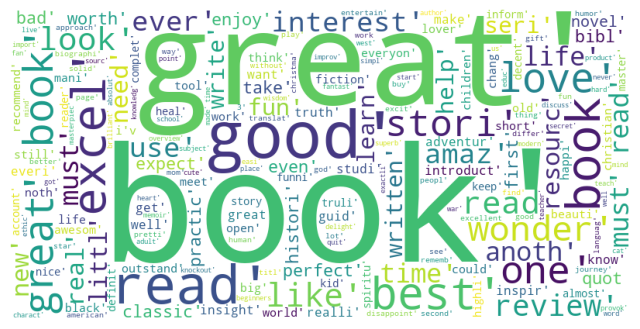

In [16]:
comment_words = str(' '.join(df['review/summary']).split())

# word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comment_words)

# if you get font error, can try the following
# wordcloud = WordCloud(font_path='/path/to/your/font.ttf', width=800, height=400, 
# background_color='white').generate(sample_text)

plt.figure(figsize=(8,8))
plt.clf()
plt.imshow(wordcloud)
plt.axis('off')
print('Word cloud for review/summary')
plt.show()

Word cloud for review/text


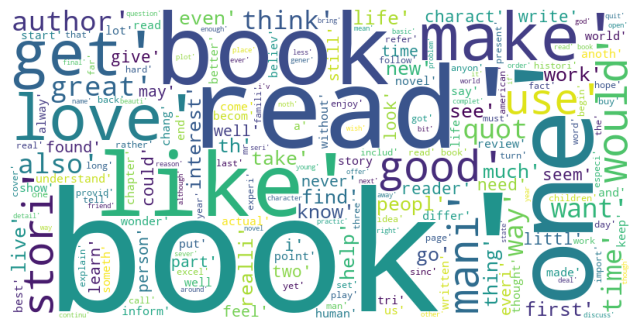

In [17]:
comment_words = str(' '.join(df['review/text']).split())

# word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comment_words)

# if you get font error, can try the following
# wordcloud = WordCloud(font_path='/path/to/your/font.ttf', width=800, height=400, 
# background_color='white').generate(sample_text)

plt.figure(figsize=(8,8))
plt.clf()
plt.imshow(wordcloud)
plt.axis('off')
print('Word cloud for review/text')
plt.show()

### **3. (8 pts) Perform text mining for each of the "review/summary" and "review/text" columns to estimate the similarity between documents. Show the similarity output tables for the first 5 documents for the summary and text columns. Paste the appropriate screenshots in the Word document.**

In [18]:
summary_corpus = [doc.split() for doc in df["review/summary"]]
text_corpus = [doc.split() for doc in df["review/text"]]

In [19]:
sum_dictionary = corpora.Dictionary(summary_corpus)
text_dictionary = corpora.Dictionary(text_corpus)

In [20]:
sum_dictionary.filter_extremes(no_below = 2, no_above = 0.75)
text_dictionary.filter_extremes(no_below = 2, no_above = 0.75)

In [21]:
sum_DFM = [sum_dictionary.doc2bow(doc) for doc in summary_corpus]
text_DFM = [text_dictionary.doc2bow(doc) for doc in text_corpus]

In [22]:
print('Summary')
print(sum_DFM)
print('Text')
print(text_DFM)

Summary
[[(0, 1)], [(1, 1)], [(2, 1), (3, 1)], [(4, 1), (5, 1)], [], [(6, 1), (7, 1)], [(8, 1)], [(9, 1), (10, 1)], [(9, 1), (11, 1)], [(9, 1), (12, 1), (13, 1)], [], [(5, 1), (14, 1), (15, 1), (16, 1)], [(17, 1), (18, 1), (19, 1), (20, 1)], [(21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1)], [(27, 1), (28, 1)], [(9, 1), (29, 1)], [(13, 1), (30, 1), (31, 1)], [(32, 1)], [(33, 1)], [(13, 1), (31, 1), (34, 1)], [(9, 1), (35, 1), (36, 1)], [(25, 1), (37, 1)], [(38, 1), (39, 1)], [(29, 1), (40, 1)], [(19, 1), (34, 1), (41, 1)], [(9, 1), (13, 1), (31, 1)], [(42, 1), (43, 1)], [], [], [(31, 1)], [(44, 1)], [(39, 1), (45, 1), (46, 1)], [(36, 1)], [(31, 1), (47, 1)], [(9, 1)], [(7, 1), (48, 1)], [(9, 1), (49, 1), (50, 1), (51, 1)], [(31, 1), (52, 1)], [(27, 1), (39, 1)], [], [(2, 1), (27, 1), (53, 1)], [(49, 1), (54, 1)], [(5, 1)], [], [(55, 1)], [(52, 1)], [(3, 1), (39, 1), (56, 1)], [(57, 1), (58, 1)], [(5, 1), (59, 1), (60, 1)], [(53, 1), (61, 1)], [(62, 1), (63, 1), (64, 1), (65, 1)], 

In [23]:
print('Summary')
print('Number of documents:', len(sum_DFM))
print('Text')
print('Number of documents:', len(text_DFM))

Summary
Number of documents: 1000
Text
Number of documents: 1000


In [24]:
print('Summary')
print('Number of unique tokens:', len(sum_dictionary))
print('Text')
print('Number of unique tokens:', len(text_dictionary))

Summary
Number of unique tokens: 386
Text
Number of unique tokens: 5709


In [25]:
sum_simil = MatrixSimilarity(sum_DFM, num_features=len(sum_dictionary))
sum_distance = 1 - sum_simil[sum_DFM]

# convert simil to a data frame
sum_sim = pd.DataFrame(sum_simil[sum_DFM])
sum_sim[2]

0      0.0
1      0.0
2      1.0
3      0.0
4      0.0
      ... 
995    0.0
996    0.0
997    0.0
998    0.0
999    0.0
Name: 2, Length: 1000, dtype: float32

In [26]:
simil = MatrixSimilarity(text_DFM, num_features=len(text_dictionary))
text_distance = 1 - simil[text_DFM]

# convert simil to a data frame
text_sim = pd.DataFrame(simil[text_DFM])
text_sim[2]

0      0.077152
1      0.200250
2      1.000000
3      0.000000
4      0.166009
         ...   
995    0.041487
996    0.025717
997    0.195047
998    0.207020
999    0.136386
Name: 2, Length: 1000, dtype: float32

In [ ]:
# train model
model = Word2Vec(text_corpus, min_count=1, workers=3, window=3, sg=0)

# most similar words to 'state'
model.wv.most_similar("read", topn=10)

[('book', 0.999118447303772),
 ('one', 0.9990425109863281),
 ('great', 0.9990081787109375),
 ('author', 0.998968780040741),
 ('use', 0.9989442825317383),
 ('first', 0.9989421367645264),
 ('like', 0.9989224672317505),
 ('much', 0.9989215731620789),
 ('even', 0.9989075660705566),
 ('stori', 0.9989042282104492)]

In [ ]:
# train model
model = Word2Vec(summary_corpus, min_count=1, workers=3, window=3, sg=0)

# most similar words to 'state'
model.wv.most_similar("read", topn=10)

KeyError: "Key 'read' not present in vocabulary"

### **4. (10 pts) Perform topic modeling on “review/text” using LDA model and generate 6 topics. In the word document, show the topic model output for each of the 6 topics as the linear combination of the terms. For 2 of the topics, write a short description in 2-3 sentences for each topic.**

In [28]:
# Tokenize the documents in the Text column
corpus = [doc.split() for doc in df["review/text"]]

# create DFM
import gensim
from gensim import corpora, models

# Create the term dictionary of the corpus
dictionary = corpora.Dictionary(corpus)

dictionary.filter_extremes(no_below = 2, no_above = 0.75)

# Convert the corpus into Document Term Matrix
DFM = [dictionary.doc2bow(doc) for doc in corpus]

In [29]:
n_topics = 6
ldamodel = models.LdaModel(DFM, num_topics=n_topics, id2word=dictionary, passes=40)

print(ldamodel.print_topics(num_topics=n_topics, num_words=10))

[(0, '0.020*"book" + 0.012*"read" + 0.007*"like" + 0.007*"one" + 0.007*"get" + 0.006*"book." + 0.006*"write" + 0.005*"would" + 0.005*"love" + 0.005*"great"'), (1, '0.027*"book" + 0.008*"read" + 0.005*"like" + 0.005*"one" + 0.005*"mani" + 0.004*"book," + 0.004*"well" + 0.004*"much" + 0.004*"stori" + 0.004*"good"'), (2, '0.021*"book" + 0.011*"one" + 0.009*"read" + 0.007*"like" + 0.005*"stori" + 0.005*"time" + 0.005*"take" + 0.005*"make" + 0.005*"use" + 0.005*"get"'), (3, '0.022*"book" + 0.009*"read" + 0.009*"one" + 0.005*"mani" + 0.005*"stori" + 0.005*"love" + 0.004*"use" + 0.004*"help" + 0.004*"new" + 0.004*"get"'), (4, '0.009*"book" + 0.008*"stori" + 0.007*"read" + 0.006*"charact" + 0.006*"time" + 0.006*"one" + 0.006*"life" + 0.005*"live" + 0.005*"love" + 0.005*"make"'), (5, '0.034*"book" + 0.013*"read" + 0.007*"would" + 0.006*"one" + 0.006*"like" + 0.006*"mani" + 0.006*"author" + 0.005*"help" + 0.005*"make" + 0.005*"good"')]


In [30]:
import pyLDAvis
pyLDAvis.enable_notebook()

import pyLDAvis.gensim_models
vis = pyLDAvis.gensim_models.prepare(ldamodel, DFM, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.046345  0.002432       1        1  38.105464
0      0.027657 -0.054537       2        1  15.532992
1      0.038590  0.003753       3        1  13.295955
2      0.028324 -0.039302       4        1  12.092304
4     -0.131713 -0.025880       5        1  11.144440
3     -0.009203  0.113534       6        1   9.828846, topic_info=        Term         Freq        Total Category  logprob  loglift
2       book  1570.000000  1570.000000  Default  30.0000  30.0000
38       one   438.000000   438.000000  Default  29.0000  29.0000
88     stori   258.000000   258.000000  Default  28.0000  28.0000
193  charact   158.000000   158.000000  Default  27.0000  27.0000
356     life   155.000000   155.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
125   author    18.021112   216.821715   Topic6  -5.8216  -0.1677
74      like    19.744237   358.360728   Topic6  -5.7302  -0.5788
422  written    15.379641   125.476808   Topic6  -5.9801   0.2208
147     make    16.512418   264.302490   Topic6  -5.9090  -0.4531
384     give    15.565294   148.830036   Topic6  -5.9681   0.0621

[511 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
3520      6  0.857142   "for
2563      1  0.052341  &amp;
2563      2  0.785113  &amp;
2563      3  0.052341  &amp;
2563      4  0.104682  &amp;
...     ...       ...    ...
850       1  0.288130  young
850       2  0.016007  young
850       3  0.304137  young
850       5  0.240108  young
850       6  0.160072  young

[1064 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 2, 3, 5, 4])

### **5. (15 pts) Build predictive models for review/score, as follows:**

### **a. Apply SVD to extract 5 components from the “review/text” column.**

In [31]:
tfidf = models.TfidfModel(DFM)
DFM_tfidf = tfidf[DFM]

n_SVD = 5
SVD_model = models.LsiModel(DFM_tfidf, id2word=dictionary, num_topics=n_SVD)
SVD = SVD_model[DFM_tfidf]

# convert results into array
svd_array = gensim.matutils.corpus2csc(SVD).T.toarray()

# convert results to data frame
svd_df = pd.DataFrame(svd_array)

# show SVD results - reduced vector representation of the documents
svd_df

/Users/jakebrulato/Documents/GitHub/Advanced_BA/.venv/lib/python3.10/site-packages/gensim/models/lsimodel.py:963: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(


,0,1,2,3,4
0,0.056068,0.000204,0.033193,-0.037998,-0.004538
1,0.186627,-0.052751,-0.005235,-0.047654,-0.047047
2,0.129800,0.099163,-0.009927,0.047495,-0.039875
3,0.078694,-0.081409,0.056244,0.020642,0.012065
4,0.166263,-0.056891,-0.060095,0.023450,-0.013355
...,...,...,...,...,...
995,0.146767,-0.017019,-0.136191,0.010730,-0.007138
996,0.091584,0.032464,-0.061260,0.131646,-0.019815
997,0.098140,0.070114,-0.063184,0.030517,-0.094912
998,0.079614,0.002981,0.034036,-0.045857,-0.021683


In [ ]:
# prepare data frame for predictive models
model_df = pd.concat([papers.reset_index()["Author"], svd_df], axis=1, ignore_index=True).rename({0:"Author"}, axis=1)
model_df

### **b. Combine two non-text columns with the 5 extracted components and build a decision tree model to predict the “review/score”. Call it Model-1.**

### **c. Report the confusion matrix of Model 1.**

### **d. Repeat tasks 5a-c with SVD to extract 8 components and build a predictive model. Call it Model-2. Report the confusion matrix of Model-2.**

### **e. Which model performs better?  Explain your answer.**